In [649]:
import requests
import os
import datetime
import locale

import scipy.optimize
import pandas as pd
import tqdm
from bs4 import BeautifulSoup

import DownloadTop2000

1. Downloaden data
2. Cleanen data
3. Feature engineering
4. Bepalen aantal stemmen per positie  
  1. Zipfs law
  1. Meindertsma model
  1. A / (X + N)
5. Univariate analyse
1. Model

## Read

In [1010]:
locale.setlocale(locale.LC_TIME, 'nl_NL.utf8') # We download from dutch wikipedia, so we need dutch month names
einde_stemperiode = pd.read_excel('Data\EindeStemperiode.xlsx').dropna(subset=['EindeStemperiode']).sort_values('EindeStemperiode')

In [ ]:

# URL_TOP2000_HISTORY = 'https://nl.wikipedia.org/wiki/Lijst_van_Radio_2-Top_2000%27s'
# w = WikipediaTableExtractor(URL_TOP2000_HISTORY, [1], [0])
# data = w.extract_table_as_dataframe()

# queen_link = 'https://nl.wikipedia.org/wiki/Queen_(hoofdbetekenis)'
# w = WikipediaTableExtractor(queen_link, [1], [], attrs={'class': 'infobox'})
# data_queen = w.extract_table_as_dataframe()

In [1097]:
def read():
    df = pd.concat([read_top2000_history_from_wikipedia(),
                    get_artist_and_song_links()], axis='columns')
    
    notering, song, songartist, artist = split_top_2000(df)
    return notering, song, songartist, artist
notering, song, songartist, artist = read()

In [1086]:
artist[artist.groupby('Name')['Link'].transform('nunique').gt(1)]

,Name,Link
ArtistID,,
5450432903032306465,Nena,https://nl.wikipedia.org/wiki/Nena_(band)
-5498135473693705893,Nena,https://nl.wikipedia.org/wiki/Nena_(zangeres)
-7895667553444934869,Mr. Big,https://nl.wikipedia.org/wiki/Mr._Big_(Amerika...
7622141836930366900,Mr. Big,https://nl.wikipedia.org/wiki/Mr._Big_(Britse_...


In [1431]:
def get_info_from_infobox(infobox):
    '''
    Extracts all information from an infobox element to a dictionary
    
    While we could use pd.read_html() directly, this seems to be quite a bit cleaner
    '''
    ret = {}
    for line in infobox:
        elements = line.find_all('td')
        if len(elements) == 1:
            print(elements[0].text)
        if len(elements) == 2:
            ret[elements[0].get_text()] = elements[1].get_text().strip()
    return ret

def find_infobox_on_page(link: str):
    '''
    link must be a Wikipedia page
    '''
    r = requests.get(link)
    soup = BeautifulSoup(r.content, 'html.parser')
    for br in soup.find_all("br"):
        br.replace_with(", " + br.text)
    try:
        infobox = soup.find('table', class_='infobox').find_all('tr')
    except AttributeError:  # No infobox on page
        return 
    return infobox

def read_infobox_details(links):
    '''
    
    '''
    details = {}
    for link in tqdm.tqdm(links):
        infobox = find_infobox_on_page(link)
        if infobox:
            details[link] = get_info_from_infobox(infobox)
    return details
        
def clean_artist_data(dct):
    artist = (pd.DataFrame.from_dict(dct, orient='index')
              .reset_index()
              .rename(columns={'index': 'Link'})
              .rename(columns= lambda c: c.strip())
             .assign(Overleden = lambda df: pd.to_datetime(df['Overleden'], errors='coerce', format='%d %B %Y', exact=False))
             )
    return artist

def feature_engineer_artist(artist):
    artist = artist.assign(IsNederlands = lambda df: (df[['Oorsprong', 'Land', 'Geboorteland', 'Land van oorsprong']]
                                                      .apply(lambda c: c.str.lower().str.contains('nederland')).any('columns')),
                           IsOverleden = lambda df: df['Overleden'].gt('2000-01-01'))
    
    # Split because merge_asof only works if there are no NULLs - and Overleden is NULL if artist has not passed away
    artist_levend = artist[~artist['IsOverleden']].copy()
    artist_overleden = artist[artist['IsOverleden']].copy().reset_index().sort_values('Overleden')
    artist_overleden = (pd.merge_asof(artist_overleden, einde_stemperiode, left_on='Overleden', right_on='EindeStemperiode', direction='forward')
                        .set_index('index')
                       )
    
    artist = pd.concat([artist_overleden, artist_levend], sort=False)
    return artist

In [1432]:
def add_artist_details(artist: pd.DataFrame):
    artist_details = clean_artist_data(read_infobox_details(artist['Link'])).pipe(feature_engineer_artist)
    artist = artist.reset_index().merge(artist_details, on='Link', how='left', validate='one_to_one').set_index('ArtistID')
    return artist

In [1433]:
read_infobox_details(artist['Link'].head())

 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  4.53it/s]

Danny Vera




Algemene informatie

Werk



Officiële website, (en)  IMDb-profiel, 



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00,  4.01it/s]

Queen






Bandleden Queen en Diego Maradona in Argentinië, 1981

Achtergrondinformatie

Leden

Oud-leden



Officiële website, (en)  IMDb-profiel, (en)  Allmusic-profiel, (en)  Last.fm-profiel, 

Eagles




Van links naar rechts: Glenn Frey, Don Henley, Joe Walsh en Timothy B. Schmit tijdens een optreden in 2008

Achtergrondinformatie

Leden

Oud-leden



Officiële website, (en)  IMDb-profiel, (en)  Allmusic-profiel, 



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  3.86it/s]

Billy Joel




Billy Joel in 2009

Algemene informatie

Werk



Officiële website, (en)  IMDb-profiel, (en)  Allmusic-profiel, (en)  Last.fm-profiel, 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]






Led Zeppelin in 2007

Achtergrondinformatie

Oud-leden



Officiële website, (en)  IMDb-profiel, (en)  Allmusic-profiel, (en)  Last.fm-profiel, 



{'https://nl.wikipedia.org/wiki/Danny_Vera': {'Geboren': '31 mei 1977, Middelburg',
  'Land': 'Nederland',
  'Jaren actief': '1999-heden',
  'Genre(s)': 'Americana,, Pop,, Singer-songwriter',
  'Label(s)': 'Excelsior',
  'Portaal\xa0  \xa0\n': 'Muziek'},
 'https://nl.wikipedia.org/wiki/Queen_(hoofdbetekenis)': {'Jaren\xa0actief': '1970 - heden',
  'Oorsprong': 'Londen',
  'Genre(s)': 'Rock, Glamrock, Hardrock',
  'Label(s)': 'Capitol Records, Parlophone, EMI, Hollywood Records, Elektra Records',
  'Manager': 'Jim "Miami" Beach',
  'Verwante\xa0acts': 'Smile',
  'Gitarist / Zang': 'Brian May',
  'Drummer / Zang': 'Roger Taylor',
  'Leadzanger': 'Freddie Mercury † (1970-1991)',
  'Bassist': 'John Deacon (1971-1997)',
  'Portaal\xa0  \xa0\n': 'Muziek'},
 'https://nl.wikipedia.org/wiki/Eagles': {'Jaren\xa0actief': '1971-1980, 1994-heden',
  'Oorsprong': 'Los Angeles',
  'Genre(s)': 'Rock, countryrock',
  'Label(s)': 'Asylum Records, Geffen Records',
  '': 'Glenn Frey , 1971-2016 †[1]',
  '

In [1409]:
rho = np.log(200/3) / np.log(2000)

In [1410]:
rho

0.5525271637458875

In [1099]:
artist = add_artist_details(artist)

100%|██████████████████████████████████████████████████████████████████████████████| 1969/1969 [05:43<00:00,  5.73it/s]


In [1413]:
def votes_zipf_law(position, votes_first_place=25000, rho=0.55):
    return votes_first_place / (position ** rho)

In [1419]:
def total_votes_zipf(nr_songs=5000):
    return sum(votes_zipf_law(i) for i in range(1, nr_songs))

def pct_votes_zipf(position):
    return votes_zipf_law(position)/total_votes_zipf()

In [1420]:
def nr_votes_per_position(position, votes_first_place=25000, diff_factor=30):
    '''
    Assuming Zipf's distribution, calculate the number of votes at a certain position of the TOP2000
    
    Source: https://www.petermeindertsma.nl/blog/benadering-aantal-stemmen-per-liedje-in-de-top-2000-van-2014/
    '''
    return votes_first_place / (1 + ( (position - 1) / diff_factor))

def total_votes(nr_songs=5000):
    return sum(nr_votes_per_position(i) for i in range(1, nr_songs))

def pct_votes(position):
    return nr_votes_per_position(position)/total_votes()

In [1425]:
total_votes_zipf()

2523959.933798863

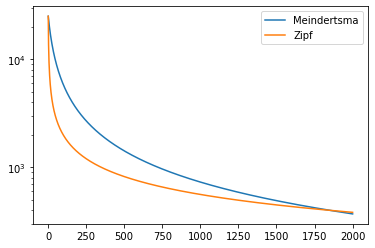

In [1427]:
xrange = range(1, 2001)
votes_meindertsma = [nr_votes_per_position(x) for x in xrange]
votes_zipf = [votes_zipf_law(x) for x in xrange]
plt.semilogy(xrange, votes_meindertsma, label='Meindertsma')
plt.semilogy(xrange, votes_zipf, label='Zipf')
plt.legend()

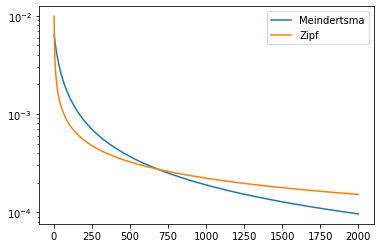

In [1429]:
xrange = range(1, 2001)
votes_meindertsma = [pct_votes(x) for x in xrange]
votes_zipf = [pct_votes_zipf(x) for x in xrange]
plt.semilogy(xrange, votes_meindertsma, label='Meindertsma')
plt.semilogy(xrange, votes_zipf, label='Zipf')
plt.legend()

In [1198]:
nr_votes_per_position(1999)

369.8224852071006

In [1111]:
notering = notering.assign(PctVotes = lambda df: pct_votes(df['Rank']))

# Clean from here

In [1105]:
def validate_top2000(df):
    assert (df.groupby('Year')['Rank'].apply(set) == set(range(1, 2001))).all()
    assert df['Year'].ge(df['YearMade']).all()
    assert ~df.duplicated(subset=['Title', 'Artist', 'Year']).any(), df[df.duplicated(subset=['Title', 'Artist', 'Year'])]
    assert df.groupby(['Title', 'Artist'])['YearMade'].nunique().eq(1).all()

In [1309]:
analysis = notering.merge(song, left_on='SongID', right_index=True).merge(songartist).merge(artist, left_on='ArtistID', right_index=True, suffixes=('Song', 'Artist'))

In [1318]:
def feature_engineer(df):
    df = df.assign(NrArtists = lambda df: df['SongID'].map(songartist.groupby('SongID').size()))
    return df

In [1319]:
analysis = analysis.pipe(feature_engineer)

In [1331]:
analysis_solo_songs = analysis.query('NrArtists == 1').copy()

In [1335]:
overlijdens_datum_per_song = analysis.groupby('SongID')['JaarTop2000'].first()

In [1255]:
def normalize_song_by_year(series, years_to_normalize=2):
    series.index -= overlijdens_datum_per_song.loc[series.name]
    series /= series.loc[-years_to_normalize:-1].mean()
    return series


In [1333]:
songs_with_overleden_artist = overlijdens_datum_per_song[overlijdens_datum_per_song.notnull()].index

In [1334]:
song_boost = (analysis.drop_duplicates(['Year', 'SongID']).set_index(['Year', 'SongID'])['PctVotes'].unstack(fill_value=0.5*pct_votes(2000)).stack().unstack()
 [songs_with_overleden_artist].apply(normalize_song_by_year)
)

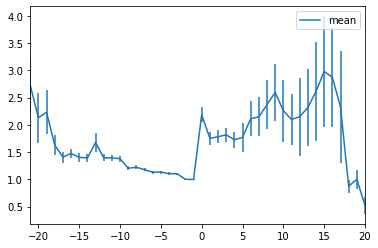

In [1260]:
song_boost.agg(['mean', 'sem', 'count'], axis='columns').plot(y='mean', yerr='sem')

In [1290]:
songartist.groupby('SongID').size()

SongID
-9217604269549002759    1
-9217147338233199048    1
-9216685527760713124    1
-9215832655083511246    1
-9212027831474186854    1
                       ..
 9205302869858850487    1
 9212059776917316069    1
 9216648079086429949    1
 9218260997627205107    1
 9219787651044058869    2
Length: 4574, dtype: int64

In [1288]:
def find_before_death_song_popularity(songID):
    try:
        return notering.loc[(notering['SongID'] == songID) & (notering['Year'] == overlijdens_datum_per_song.loc[songID] - 1), 'PctVotes'].values[0]
    except IndexError:
        return 0

In [1395]:
song

,Title,YearMade,Link
SongID,,,
-216596183752066366,Roller Coaster,2019,https://nl.wikipedia.org/wiki/Roller_Coaster
4576538136336661590,Bohemian Rhapsody,1975,https://nl.wikipedia.org/wiki/Bohemian_Rhapsody
2452410927666291751,Hotel California,1977,https://nl.wikipedia.org/wiki/Hotel_California...
4968250506905680221,Piano Man,1974,https://nl.wikipedia.org/wiki/Piano_Man_(lied)
6464884497625435207,Stairway to Heaven,1971,https://nl.wikipedia.org/wiki/Stairway_to_Heav...
...,...,...,...
-3914863514847738334,Substitute,1966,https://nl.wikipedia.org/wiki/Substitute_(The_...
-3421086357523163019,Who Are You,1978,https://nl.wikipedia.org/wiki/Who_Are_You_(num...
7245760820830897221,A Brand New Day,1979,https://nl.wikipedia.org/w/index.php?title=A_B...


In [1396]:
song_effect_overlijden = (pd.concat([song_boost.loc[0].rename('OverlijdensBoost'),
                                     overlijdens_datum_per_song,
                                     songartist.groupby('SongID').size().rename('AantalArtiesten'),
                                    song['YearMade']], axis='columns', join='inner')
                             .assign(BeforeDeathPopularity = lambda df: [find_before_death_song_popularity(songid) for songid in df.index],
                                    )
                            )

In [1397]:
song_effect_overlijden

,OverlijdensBoost,JaarTop2000,AantalArtiesten,YearMade,BeforeDeathPopularity
SongID,,,,,
-9212027831474186854,1.000000,2012.0,1,1975,0.000000
-9187230990483862425,6.796645,2009.0,1,1978,0.000804
-9062739638009593936,1.000000,2020.0,1,1988,0.000000
-9014714459486618429,1.000000,2002.0,1,1966,0.000000
-8973767009978291509,1.846320,2016.0,1,2013,0.000000
...,...,...,...,...,...
9074555685393046974,1.000000,2004.0,1,1991,0.000000
9077279463296766511,7.051028,2016.0,1,1986,0.000147
9129018106518831364,1.000000,2009.0,1,1984,0.000000


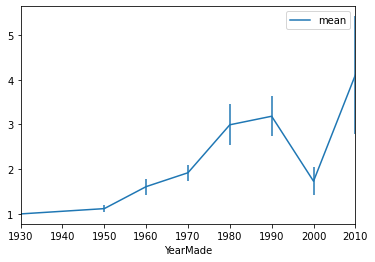

In [1404]:
song_effect_overlijden.groupby(song_effect_overlijden['YearMade'] // 10 * 10)['OverlijdensBoost'].agg(['mean', 'sem', 'std', 'count']).plot(y='mean', yerr='sem')

In [1301]:
song_effect_overlijden.groupby('AantalArtiesten')['OverlijdensBoost'].agg(['mean', 'sem', 'std', 'count'])

,mean,sem,std,count
AantalArtiesten,,,,
1,2.247089,0.148957,2.770758,346
2,1.709983,0.172801,1.119880,42
3,1.572778,NaN,NaN,1


In [1306]:
song_effect_overlijden.groupby('JaarTop2000')['OverlijdensBoost'].agg(['mean', 'sem', 'std', 'count'])

,mean,sem,std,count
JaarTop2000,,,,
2000.0,1.128542,0.242126,0.593084,6
2001.0,1.368229,0.150839,0.584198,15
2002.0,1.157345,0.134616,0.466325,12
2003.0,1.435473,0.144215,0.706507,24
2004.0,2.269813,1.060028,5.405105,26
2005.0,1.126239,0.228978,0.396602,3
2006.0,1.033951,0.022110,0.073330,11
2007.0,1.918457,0.676477,2.139207,10
2009.0,4.517936,0.588493,4.284294,53


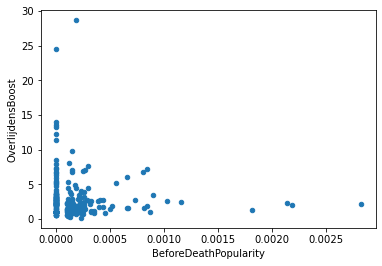

In [1307]:
song_effect_overlijden.plot(x='BeforeDeathPopularity', y='OverlijdensBoost', kind='scatter')

In [ ]:
song_effect_overlijden.groupby('AantalArtiesten')['OverlijdensBoost'].agg(['mean', 'sem', 'std', 'count'])

In [ ]:
effect_overlijden = (pd.concat([song_boost.loc[0].rename('OverlijdensBoost'),
                                artist.loc[artist['IsOverleden'] == True, ['Name', 'Overleden', 'IsNederlands', 'EindeStemperiode', 'JaarTop2000']]],
                               axis='columns')
                     .assign(DaysToStemperiode = lambda df: df['Overleden'].sub(df['EindeStemperiode']).dt.days,
                            BeforeDeathPopularity = lambda df: [find_popularity_before_passing_away(artistname) for artistname in df.index],
                            LogPopularity = lambda df: np.log10(df['BeforeDeathPopularity']))
                     .replace([np.inf, -np.inf], np.nan)
                     .dropna()
                    )

In [1336]:
votes_per_year = analysis_solo_songs.groupby(['Year', 'ArtistID'])['PctVotes'].sum().unstack(fill_value=0)

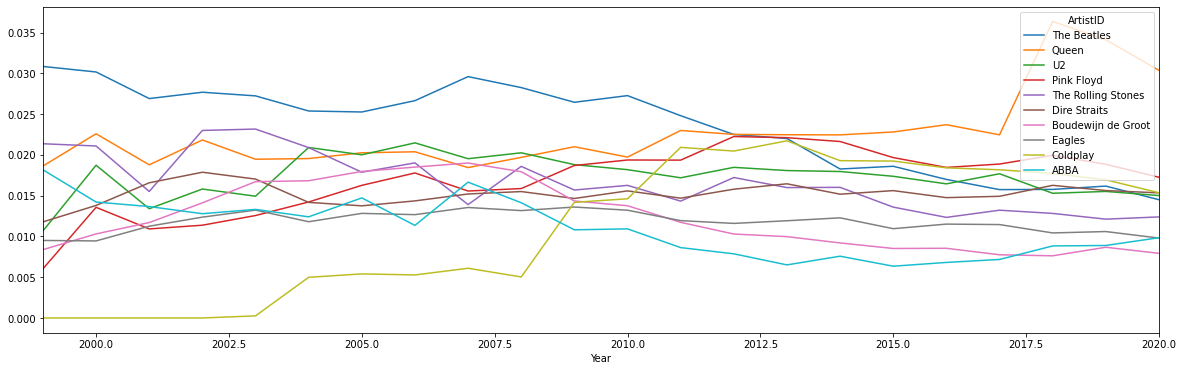

In [1337]:
votes_per_year[votes_per_year.sum().nlargest(10).index].rename(columns=artist['Name'].to_dict()).plot(figsize=(20, 6))

In [1155]:
def mape_by_window(df, window=3):
    average = np.around(votes_per_year.rolling(window).mean().shift(), 5)
    mape = (votes_per_year.sub(average).abs()#.div(average) # 
             .melt()
             .replace([np.inf, -np.inf], np.nan).dropna()
             .mean()
           )
    return mape

In [1156]:
{i: mape_by_window(votes_per_year, i) for i in range(1, 5)}

{1: ArtistID    8.364701e+15
 value       8.722535e-05
 dtype: float64,
 2: ArtistID    8.364701e+15
 value       8.917011e-05
 dtype: float64,
 3: ArtistID    8.364701e+15
 value       9.686521e-05
 dtype: float64,
 4: ArtistID    8.364701e+15
 value       1.062309e-04
 dtype: float64}

In [1405]:
artist.rename(columns = lambda s: s.lower()).filter(regex='(?<!achtergrond)(?<!koor)zang')#.columns.tolist()

,gitarist / zang,drummer / zang,leadzanger,zang,"zanger, gitarist","zanger, pianist en gitarist","gitarist, zanger","toetsenist, zanger","bassist, zanger",zanger-gitarist,...,"zanger, toetsenist",bassist; zang,percussie; zang,"gitaar, mondharmonica, zang","zang, drum & percussie","leadzang, piano, gitaar, klarinet","gitarist, tweede leadzang",leadzanger/bassist,"gitaar, basgitaar, zang",zang en mondharmonica
ArtistID,,,,,,,,,,,,,,,,,,,,,
-8690994415943565079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6383657206135249673,Brian May,Roger Taylor,Freddie Mercury † (1970-1991),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4672387555473794165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2103308877230011944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8915147113433716306,NaN,NaN,NaN,Robert Plant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4299292403079461562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6519136722687974554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314075066777351469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1394]:
artist[artist['gitarist, tweede leadzang'].notnull()]

,Name,Link,Geboren,Land,Jaren actief,Genre(s),Label(s),Portaal,Jaren actief,Oorsprong,...,Budget,Opbrengst,Overige nominaties,zang en mondharmonica,sologitaar,IsNederlands,IsOverleden,EindeStemperiode,JaarTop2000,Bron
ArtistID,,,,,,,,,,,,,,,,,,,,,
-1586309683776652303,The Rubettes,https://nl.wikipedia.org/wiki/The_Rubettes,NaN,NaN,NaN,NaN,NaN,Muziek,1973-heden,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN


In [1135]:
window=2
average = np.around(votes_per_year.rolling(window).mean().shift(), 5)
votes_per_year.sub(average).abs().div(average).melt().replace([np.inf, -np.inf], np.nan).dropna().mean()#ignore_index=False)

value    0.440866
dtype: float64

In [392]:
# outc = votes_per_year.sub(average).abs().div(average).reset_index().melt(id_vars=['Jaar']).replace([np.inf, -np.inf], np.nan).dropna()

In [1136]:
# def normalize(series, years_to_normalize=3):
#     series.index -= series.idxmax()
#     series /= series.loc[-years_to_normalize:-1].mean()
#     return series

# normalize(votes_per_year['Ramses Shaffy'])

In [1140]:
artist['IsOverleden'].sum()

135

In [1338]:
artist

,Name,Link,Geboren,Land,Jaren actief,Genre(s),Label(s),Portaal,Jaren actief,Oorsprong,...,Budget,Opbrengst,Overige nominaties,zang en mondharmonica,sologitaar,IsNederlands,IsOverleden,EindeStemperiode,JaarTop2000,Bron
ArtistID,,,,,,,,,,,,,,,,,,,,,
-8690994415943565079,Danny Vera,https://nl.wikipedia.org/wiki/Danny_Vera,"31 mei 1977, Middelburg",Nederland,1999-heden,"Americana,, Pop,, Singer-songwriter",Excelsior,Muziek,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,NaT,NaN,NaN
-6383657206135249673,Queen,https://nl.wikipedia.org/wiki/Queen_(hoofdbete...,NaN,NaN,NaN,"Rock, Glamrock, Hardrock","Capitol Records, Parlophone, EMI, Hollywood Re...",Muziek,1970 - heden,Londen,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
-4672387555473794165,Eagles,https://nl.wikipedia.org/wiki/Eagles,NaN,NaN,NaN,"Rock, countryrock","Asylum Records, Geffen Records",Muziek,"1971-1980, 1994-heden",Los Angeles,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
-2103308877230011944,Billy Joel,https://nl.wikipedia.org/wiki/Billy_Joel,9 mei 1949,Verenigde Staten,1964–heden,"Rock, Pop, jazz, klassiek","Columbia Records, Family Productions, Famous M...",Muziek,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
8915147113433716306,Led Zeppelin,https://nl.wikipedia.org/wiki/Led_Zeppelin,NaN,NaN,NaN,"Hardrock, Heavy metal, Bluesrock, Folkrock","Atlantic Records, Swan Song",Muziek,"1968 - 1980 , gedeeltelijke reünies in , 1985,...",Londen,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4299292403079461562,The Walker Brothers,https://nl.wikipedia.org/wiki/The_Walker_Brothers,NaN,NaN,NaN,"Blues, Rock, popmuziek","Philips Records, GTO Records",Muziek,"1964–1968 , 1975–1978",Los Angeles,...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
6519136722687974554,The Walkers,https://nl.wikipedia.org/wiki/The_Walkers,NaN,NaN,NaN,NaN,NaN,Muziek,1963 - 1989,"Maastricht, Limburg",...,NaN,NaN,NaN,NaN,NaN,False,False,NaT,NaN,NaN
314075066777351469,The Wiz Stars,https://nl.wikipedia.org/wiki/The_Wiz_(film),NaN,Verenigde Staten,NaN,NaN,NaN,Film,NaN,NaN,...,$ 24 000 000,$ 13 000 000,"Oscar , Saturn Award",NaN,NaN,False,False,NaT,NaN,NaN


In [1339]:
overleden_artiest = artist[artist['IsOverleden'] == True].index

In [1340]:
overleden_artiest

Int64Index([-7280776149485126027,  3017386811060952638, -1075092151441489476,
            -1743265419610420721, -8005812055898405850, -4885606413490392341,
              116220342227725902,   481628662362255845,  6175666567072479264,
             2866778609770077132,
            ...
            -6845188710409988821, -1586978907910833855,  5985129688823399592,
             4214076960650831524, -7078387140346428640,  6161258275223775545,
             3828082091374007467,   581534992663076015, -7011198858547004267,
            -4575814139070963084],
           dtype='int64', name='ArtistID', length=135)

In [1342]:
def normalize_by_year(series, years_to_normalize=3):
    series.index -= artist.loc[series.name, 'JaarTop2000']
    series /= series.loc[-years_to_normalize:-1].mean()
    return series

overleden_artiest = votes_per_year.columns.intersection(overleden_artiest)

votes_per_year_normalized = votes_per_year[overleden_artiest].apply(normalize_by_year, years_to_normalize=2)

In [1343]:
votes_per_year_normalized.replace(np.inf, np.nan).agg(['mean', 'sem', 'std', 'count'], axis='columns')#.plot(y='mean', yerr='std')

,mean,sem,std,count
-21.0,1.791024,1.132090,1.601017,2.0
-20.0,0.832315,0.832315,1.177071,2.0
-19.0,1.039587,0.352789,0.788860,5.0
-18.0,1.557710,0.384976,1.276821,11.0
-17.0,1.484830,0.306992,1.227970,16.0
-16.0,1.721058,0.238366,1.143165,23.0
-15.0,1.447055,0.230160,1.103808,23.0
-14.0,1.508049,0.184927,0.924634,25.0
-13.0,1.522731,0.182667,0.966584,28.0
-12.0,1.514138,0.191214,1.064636,31.0


In [1344]:
def find_popularity_before_passing_away(artistname, nr_years=2):
    year_passing_away = artist.loc[artistname, 'JaarTop2000']
    popularity = votes_per_year.loc[year_passing_away-nr_years:year_passing_away-1, artistname].mean()
    return popularity

In [1381]:
effect_overlijden = (pd.concat([votes_per_year_normalized.loc[0].rename('OverlijdensBoost'),
                                artist.loc[artist['IsOverleden'] == True, ['Name', 'Overleden', 'IsNederlands', 'EindeStemperiode', 'JaarTop2000']]],
                               axis='columns', join='inner')
                     .assign(DaysToStemperiode = lambda df: df['Overleden'].sub(df['EindeStemperiode']).dt.days,
                            BeforeDeathPopularity = lambda df: [find_popularity_before_passing_away(artistname) for artistname in df.index],
                            LogPopularity = lambda df: np.log10(df['BeforeDeathPopularity']))
                     .sort_values('BeforeDeathPopularity')
                     .drop_duplicates('Overleden') # TODO: fix the double artists in a neat way

                     .replace([np.inf, -np.inf], np.nan)
                     .dropna()
                    )

In [1367]:
effect_overlijden

,OverlijdensBoost,Name,Overleden,IsNederlands,EindeStemperiode,JaarTop2000,DaysToStemperiode,BeforeDeathPopularity,LogPopularity
ArtistID,,,,,,,,,
-1121164056026123170,0.000000,Fred Neil,2001-07-07,False,2001-12-01,2001.0,-147,0.000050,-4.300781
-3585976878549180600,0.000000,Crispian St. Peters,2010-06-08,False,2010-11-26,2010.0,-171,0.000050,-4.300110
-2042722482436215270,0.000000,Egbert Douwe,2003-12-25,True,2004-12-01,2004.0,-342,0.000052,-4.287633
-5911833757978713545,0.000000,Frankie Laine,2007-02-06,False,2007-11-30,2007.0,-297,0.000053,-4.276679
581534992663076015,2.023346,Wally Tax,2005-04-10,True,2005-12-01,2005.0,-235,0.000053,-4.271933
...,...,...,...,...,...,...,...,...,...
-817537377923960840,1.777159,Leonard Cohen,2016-11-07,False,2016-12-02,2016.0,-25,0.001779,-2.749902
-4885606413490392341,2.733101,Ramses Shaffy,2009-12-01,True,2009-12-04,2009.0,-3,0.001978,-2.703715
6175666567072479264,3.769560,Michael Jackson,2009-06-25,False,2009-12-04,2009.0,-162,0.002042,-2.689941


In [1368]:
def death_effect(x, minimum_effect=1.5, maximum_effect=3, days_start=30):
    return minimum_effect + x.add(days_start).clip(lower=0).div(days_start) * (maximum_effect - minimum_effect)

In [1369]:
popt, pcov = scipy.optimize.curve_fit(death_effect, effect_overlijden['DaysToStemperiode'], effect_overlijden['OverlijdensBoost'], [1.5, 3, 30])
perr = np.sqrt(np.diag(pcov))
popt

array([1.358895  , 2.8515358 , 9.86919958])

In [1370]:
perr

array([0.14226974, 1.23830316, 9.94410022])

In [1371]:
recency_days = 50
effect_overlijden = effect_overlijden.assign(RecencyFactor = lambda df: df['DaysToStemperiode'].add(recency_days).clip(lower=0).div(recency_days)).sort_values('RecencyFactor')

In [1372]:
effect_overlijden.groupby('IsNederlands')['OverlijdensBoost'].agg(['mean', 'sem', 'count'])

,mean,sem,count
IsNederlands,,,
False,1.445658,0.161027,52
True,1.192237,0.252276,12


In [1373]:
effect_overlijden.sort_values('OverlijdensBoost')

,OverlijdensBoost,Name,Overleden,IsNederlands,EindeStemperiode,JaarTop2000,DaysToStemperiode,BeforeDeathPopularity,LogPopularity,RecencyFactor
ArtistID,,,,,,,,,,
-1121164056026123170,0.000000,Fred Neil,2001-07-07,False,2001-12-01,2001.0,-147,0.000050,-4.300781,0.0
-7779750375836855636,0.000000,Arne Jansen & Les Cigales,2007-12-10,True,2009-12-04,2009.0,-725,0.000117,-3.933571,0.0
-30426966774550097,0.000000,Al Jarreau,2017-02-12,False,2017-12-08,2017.0,-299,0.000115,-3.939918,0.0
2760397904695673968,0.000000,Demis Roussos,2015-01-25,False,2015-11-27,2015.0,-306,0.000108,-3.964972,0.0
-5911833757978713545,0.000000,Frankie Laine,2007-02-06,False,2007-11-30,2007.0,-297,0.000053,-4.276679,0.0
...,...,...,...,...,...,...,...,...,...,...
-8005812055898405850,3.210942,George Michael,2016-12-25,False,2017-12-08,2017.0,-348,0.001031,-2.986631,0.0
2866778609770077132,3.247393,Avicii,2018-04-20,False,2018-12-07,2018.0,-231,0.000673,-3.172057,0.0
6175666567072479264,3.769560,Michael Jackson,2009-06-25,False,2009-12-04,2009.0,-162,0.002042,-2.689941,0.0


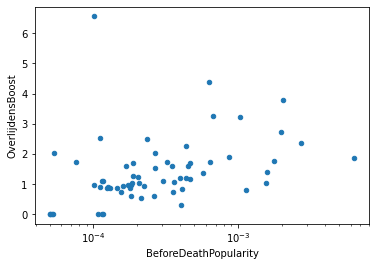

In [1374]:
effect_overlijden.plot(x='BeforeDeathPopularity', y='OverlijdensBoost', kind='scatter', logx=True)# y.assign().plot(x='LogPopularity'

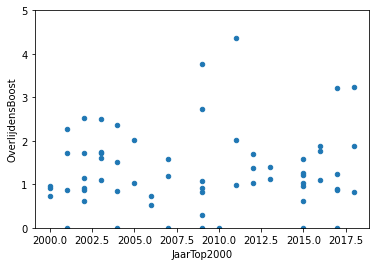

In [1375]:
effect_overlijden.plot(x='JaarTop2000', y='OverlijdensBoost', kind='scatter', ylim=(0, 5))

In [1376]:
effect_overlijden.groupby('JaarTop2000')['OverlijdensBoost'].agg(['mean', 'sem'])#.plot(y='mean', yerr='sem')

,mean,sem
JaarTop2000,,
2000.0,0.877820,0.069933
2001.0,1.210746,0.496860
2002.0,1.295660,0.286971
2003.0,1.732477,0.225319
2004.0,1.182529,0.500093
2005.0,1.532037,0.491310
2006.0,0.630800,0.097829
2007.0,0.927797,0.477415
2009.0,1.373320,0.517490


In [1377]:
import statsmodels.api as sm

In [1378]:
effect_overlijden[['RecencyFactor', 'IsNederlands', 'JaarTop2000', 'LogPopularity']].corr()

,RecencyFactor,IsNederlands,JaarTop2000,LogPopularity
RecencyFactor,1.000000,0.170232,-0.036734,0.179418
IsNederlands,0.170232,1.000000,-0.273285,-0.034374
JaarTop2000,-0.036734,-0.273285,1.000000,0.277486
LogPopularity,0.179418,-0.034374,0.277486,1.000000


In [1379]:
effect_overlijden.sort_values('OverlijdensBoost', ascending=False)

,OverlijdensBoost,Name,Overleden,IsNederlands,EindeStemperiode,JaarTop2000,DaysToStemperiode,BeforeDeathPopularity,LogPopularity,RecencyFactor
ArtistID,,,,,,,,,,
5018680863554644208,6.557750,Tom Petty,2017-10-02,False,2017-12-08,2017.0,-67,0.000101,-3.994636,0.0
-1743265419610420721,4.375007,Amy Winehouse,2011-07-23,False,2011-11-27,2011.0,-127,0.000628,-3.201871,0.0
6175666567072479264,3.769560,Michael Jackson,2009-06-25,False,2009-12-04,2009.0,-162,0.002042,-2.689941,0.0
2866778609770077132,3.247393,Avicii,2018-04-20,False,2018-12-07,2018.0,-231,0.000673,-3.172057,0.0
-8005812055898405850,3.210942,George Michael,2016-12-25,False,2017-12-08,2017.0,-348,0.001031,-2.986631,0.0
...,...,...,...,...,...,...,...,...,...,...
-30426966774550097,0.000000,Al Jarreau,2017-02-12,False,2017-12-08,2017.0,-299,0.000115,-3.939918,0.0
2760397904695673968,0.000000,Demis Roussos,2015-01-25,False,2015-11-27,2015.0,-306,0.000108,-3.964972,0.0
-5911833757978713545,0.000000,Frankie Laine,2007-02-06,False,2007-11-30,2007.0,-297,0.000053,-4.276679,0.0


In [1380]:
y = effect_overlijden['OverlijdensBoost']
X = sm.add_constant(effect_overlijden.assign(IsNederlands = lambda df: df['IsNederlands'].astype(int),
                                             JaarTop2000 = lambda df: df['JaarTop2000'].sub(df['JaarTop2000'].max()),
                                            )
                    [['RecencyFactor', 'IsNederlands', 'JaarTop2000', 'LogPopularity']]
#                     [['RecencyFactor', 'JaarTop2000']]

                   )
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       OverlijdensBoost   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2.680
Date:                 di, 05 jan 2021   Prob (F-statistic):             0.0402
Time:                        09:11:27   Log-Likelihood:                -91.715
No. Observations:                  64   AIC:                             193.4
Df Residuals:                      59   BIC:                             204.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4408      1.074      4.134      0.000       2.291       6.590
RecencyFactor     0.4526      0.623      0.727      0.470      -0.794       1.699
IsNederlands     -0.2321      0.357     -0.651      0.518      -0.946       0.482
JaarTop2000       0.0076      0.024      0.312      0.756      -0.041       0.056
LogPopularity     0.8318      0.309      2.695      0.009       0.214       1.449
==============================================================================
Omnibus:                       62.932   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              423.676
Skew:                           2.783   Prob(JB):                     1.00e-92
Kurtosis:                      14.310   Cond. No.                         96.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1184]:
effect_overlijden['PredictedBoost'] = res.predict(X)

In [1192]:
(effect_overlijden
 .assign(AbsoluteError = lambda df: df['OverlijdensBoost'].sub(df['PredictedBoost']).abs())
 .sort_values('AbsoluteError', ascending=False)
 .tail(20)
)#.plot(kind='scatter', x='DaysToStemperiode', y='AbsoluteError')

,OverlijdensBoost,Name,Overleden,IsNederlands,EindeStemperiode,JaarTop2000,DaysToStemperiode,BeforeDeathPopularity,LogPopularity,RecencyFactor,PredictedBoost,AbsoluteError
ArtistID,,,,,,,,,,,,
6957366918387892810,1.479769,Scott McKenzie,2012-08-18,False,2012-11-23,2012.0,-97,0.000208,-3.682429,0.00,1.794035,0.314266
1576337542230410685,1.278498,Andrew Gold,2011-06-03,False,2011-11-27,2011.0,-177,0.000101,-3.994201,0.00,1.592612,0.314114
-7280776149485126027,2.403918,David Bowie,2016-01-10,False,2016-12-02,2016.0,-327,0.007817,-2.106969,0.00,2.716179,0.312261
6351396282956767309,1.221744,James Brown,2006-12-25,False,2007-11-30,2007.0,-340,0.000395,-3.403263,0.00,1.438741,0.216998
-4374531564440335015,2.606772,Lou Reed,2013-10-27,False,2013-12-06,2013.0,-40,0.001600,-2.795916,0.20,2.803090,0.196317
-3398120292092159702,2.050314,Chuck Berry,2017-03-18,False,2017-12-08,2017.0,-265,0.000204,-3.690105,0.00,2.245608,0.195294
4297909478443248109,1.010145,Drafi Deutscher,2006-06-09,False,2006-12-01,2006.0,-175,0.000156,-3.805825,0.00,1.205121,0.194977
6436972420184736816,1.651398,Herman Brood,2001-07-11,True,2001-12-01,2001.0,-143,0.000789,-3.102746,0.00,1.471537,0.179861
1224638712034432495,2.323100,B.B. King,2015-05-14,False,2015-11-27,2015.0,-197,0.000434,-3.362661,0.00,2.180012,0.143088


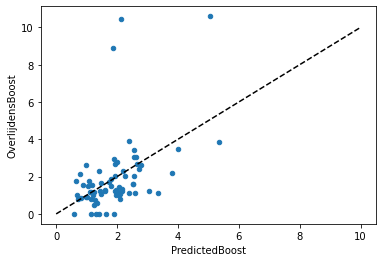

In [1188]:
effect_overlijden.plot(x='PredictedBoost', y='OverlijdensBoost', kind='scatter')
import matplotlib.pyplot as plt
plt.plot([0, 10], [0, 10], 'k--')

In [577]:
effect_overlijden.groupby(effect_overlijden['Overleden'].dt.year)['OverlijdensBoost'].agg(['mean', 'sem', 'count'])#.rolling(3)['mean'].mean().plot()

,mean,sem,count
Overleden,,,
2000,1.015701,0.310525,3
2001,1.328740,0.322018,6
2002,1.237807,0.318283,5
2003,1.384831,0.352921,6
2004,1.569295,0.546971,3
2005,1.541561,0.733439,2
2006,1.594177,0.458876,4
2007,0.347455,0.347455,3
2008,0.816831,NaN,1


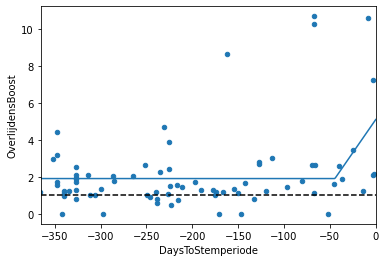

In [571]:
import datetime
import matplotlib.pyplot as plt
(effect_overlijden
 .plot(x='DaysToStemperiode', y='OverlijdensBoost', kind='scatter')
)
death_effect(pd.Series(range(-365, 1), index=range(-365, 1)), *popt).plot()
plt.axhline(1, c='k', ls='--')